### This notebook is combinaiton of all below notebooks

https://www.kaggle.com/marcobr95/predicting-bacteria-species

https://www.kaggle.com/sfktrkl/tps-feb-2022?scriptVersionId=87059305

https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense

https://www.kaggle.com/ambrosm/tpsfeb22-02-postprocessing-against-the-mutants

https://www.kaggle.com/ambrosm/tpsfeb22-03-clustering-improves-the-predictions

https://www.kaggle.com/kavehshahhosseini/tps-feb-22-autoencoder-dimensionality-reduction



<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Introduction </center></h1>
</div>
The concept of clustering is to identify similarities between objects according to their characteristics and put them in a group. These groups are known as "clusters. Similarly,  multiclass classification is the problem of classifying instances into one of three or more classes
### *Just hover over the below picture, you will understand clearly.*

<img src="https://blog.bismart.com/hs-fs/hubfs/Imported_Blog_Media/ClassificationAndClustering/Clustering%26clasification-Animales.gif?width=1200&name=Clustering%26clasification-Animales.gif">

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import os, gc, logging, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#import cudf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from scipy.spatial import ConvexHull
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import mode
from tqdm.notebook import tqdm

# Intel® Extension for Scikit-learn installation:
!pip install scikit-learn-intelex
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans, OPTICS
from pathlib import Path

from sklearnex import patch_sklearn
patch_sklearn()


import tensorflow as tf
warnings.filterwarnings("ignore")

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-feb-2022/train.csv').set_index("row_id")
test = pd.read_csv('../input/tabular-playground-series-feb-2022/test.csv').set_index("row_id")

#sample_submission = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv")

#train = train.to_pandas()
#test = test.to_pandas()

feature_cols = test.columns.tolist()

le = LabelEncoder()
train["target"] = le.fit_transform(train["target"])

for col in feature_cols:
    train[col] = train[col].astype("float32")
    test[col] = test[col].astype("float32")

In [ ]:
le.inverse_transform(train["target"] )

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Basic datacheck </center></h1>
</div>


In [ ]:
print('Train data shape:', train.shape)
print('Test data shape:', test.shape)

In [ ]:
missing_values_train = train.isna().any().sum()
print('Missing values in train data: {0}'.format(missing_values_train[missing_values_train > 0]))

missing_values_test = test.isna().any().sum()
print('Missing values in test data: {0}'.format(missing_values_test[missing_values_test > 0]))

As @ambrosm mentioned in his notebook, 
"We must not simply drop the duplicates because this would change the probability distribution. After all, if one particular measurement outcome has been measured 18 times, it should have higher weight than an outcome which has been measured only once. Fortunately, the fit() method of most scikit-learn estimators has an optional parameter sample_weight for this purpose"

In [ ]:
# Create a new dataframe without duplicates, but with an additional sample_weight column
vc = train.value_counts()
dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns=train.columns)
dedup_train2 = pd.DataFrame([list(tup) for tup in vc.index.values], columns=train.columns)
dedup_train2['sample_weight'] = vc.values


In [ ]:
from sklearn.preprocessing import LabelEncoder
TARGET = train.columns.difference(test.columns)[0]
features = dedup_train.columns[dedup_train.columns != TARGET]
# Encoding categorical features
le2 = LabelEncoder()

X_train = dedup_train[features]
y_train = pd.DataFrame(le2.fit_transform(dedup_train[TARGET]), columns=[TARGET])
sample_weight = dedup_train2['sample_weight']

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Clustering of the data </center></h1>
</div>

Typically clustering is used to minimize the dimentionality. As we can see below, the 3D data can be represented as 2D data. Same concept is applied in here.The workflow is to use various clustering techniques to reduce the dimentionality and before building the model. 

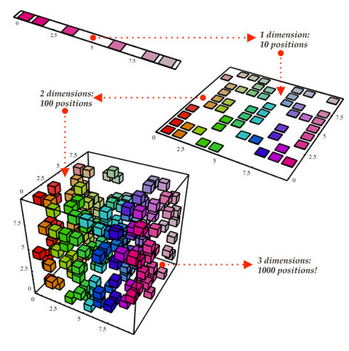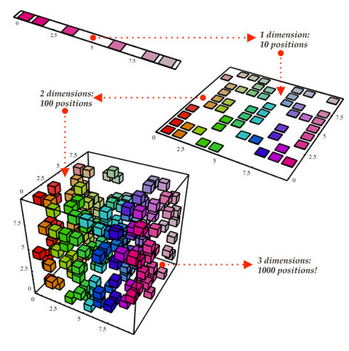

### Clustering technique -1: Autoencoder
Autoencoders are a specific type of feedforward neural networks where the input is the same as the output. They compress the input into a lower-dimensional code and then reconstruct the output from this representation. An autoencoder consists of 3 components: encoder, code and decoder. The encoder compresses the input and produces the code, the decoder then reconstructs the input only using this code. For Indepth explanation can be found in https://www.youtube.com/watch?v=Rdpbnd0pCiI

In [ ]:
X=dedup_train[feature_cols]
y=dedup_train["target"]

In [ ]:
n_components = 2

tf.random.set_seed(42)
KI = tf.keras.initializers.glorot_uniform(seed=42)

encoder_input = tf.keras.layers.Input(shape=(dedup_train[features].shape[1],), name="Input")
encoder_x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=KI, name="Encoder")(encoder_input)
encoder_output = tf.keras.layers.Dense(n_components, activation="swish", kernel_initializer=KI, name="Bottleneck")(encoder_x)

decoder_x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=KI, name="Decoder")(encoder_output)
decoder_output = tf.keras.layers.Dense(dedup_train[features].shape[1], kernel_initializer=KI, name="Output")(decoder_x)

encoder = tf.keras.Model(encoder_input, encoder_output)
autoencoder = tf.keras.Model(encoder_input, decoder_output)

autoencoder.compile(optimizer="adam", loss="mse")

history = autoencoder.fit(dedup_train[features], dedup_train[features], epochs=5)
tf.keras.utils.plot_model(autoencoder, show_shapes=True, rankdir="LR")

In [ ]:
feature_cols = test.columns.tolist()
enc_x = encoder.predict(dedup_train[features])
enc_t = encoder.predict(test[features])

enc_cols = []
for i in range(n_components):
    col = f"ENC{i+1}"
    dedup_train[col] = enc_x[:,i]
    dedup_train[col] = enc_x[:,i]
    test[col] = enc_t[:,i]
    test[col] = enc_t[:,i]
    enc_cols.append(col)

del autoencoder, encoder, history, enc_x, enc_t
gc.collect()

df_x = dedup_train[["ENC1", "ENC2", "target"]].copy()
df_x["target"] = le.inverse_transform(df_x["target"])
df_t = test[["ENC1", "ENC2"]].copy()

### Clustering technique -2: Kmeans

In [ ]:
gc.collect()
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000, n_init=100)

df_x["cluster"] = kmeans.fit_predict(dedup_train[enc_cols])
df_t["cluster"] = kmeans.predict(test[enc_cols])


### An example of how clustering will look like

In [ ]:
plt.figure(figsize=(25,10))
centroids_list = kmeans.cluster_centers_
plt.subplot(1,2,1)
sns.scatterplot(data=df_x, x="ENC1", y="ENC2", hue="cluster", alpha=0.8, palette="bright")
for c in range(n_clusters):
    cluster = df_x[df_x.cluster==c]
    hull = ConvexHull(cluster[enc_cols])
    points = cluster[enc_cols].values
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.scatter(centroids_list[:, 0], centroids_list[:, 1], s=70, c='b')
plt.title("Clusters for Train set")

plt.subplot(1,2,2)
sns.scatterplot(data=df_t, x="ENC1", y="ENC2", hue="cluster", alpha=0.8, palette="bright")
for c in range(n_clusters):
    cluster = df_t[df_t.cluster==c]
    hull = ConvexHull(cluster[enc_cols])
    points = cluster[enc_cols].values
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.scatter(centroids_list[:, 0], centroids_list[:, 1], s=70, c='b')
plt.title("Clusters for Test set")

plt.show()

### Clustering technique-3: PCA

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(dedup_train[feature_cols])
T_pca = pca.transform(test[feature_cols])

pca_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]

X_pca = pd.DataFrame(X_pca, columns=pca_cols, index=dedup_train.index)
T_pca = pd.DataFrame(T_pca, columns=pca_cols, index=test.index)

dedup_train = pd.concat([dedup_train, X_pca], axis=1)
test = pd.concat([test, T_pca], axis=1)

del pca, X_pca, T_pca

### Clustering technique-4: LDA

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
X_lda = lda.fit_transform(dedup_train[feature_cols], dedup_train["target"])
T_lda = lda.transform(test[feature_cols])

lda_cols = [f"LDA{i+1}" for i in range(X_lda.shape[1])]

X_lda = pd.DataFrame(X_lda, columns=lda_cols, index=dedup_train.index)
T_lda = pd.DataFrame(T_lda, columns=lda_cols, index=test.index)

dedup_train = pd.concat([dedup_train, X_lda], axis=1)
test = pd.concat([test, T_lda], axis=1)

del lda, X_lda, T_lda
gc.collect()

### Clustering technique-5: SVD

In [ ]:
svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42)

X_svd = svd.fit_transform(dedup_train[feature_cols])
T_svd = svd.transform(test[feature_cols])

svd_cols = [f"SVD{i+1}" for i in range(X_svd.shape[1])]

X_svd = pd.DataFrame(X_svd, columns=svd_cols, index=dedup_train.index)
T_svd = pd.DataFrame(T_svd, columns=svd_cols, index=test.index)

dedup_train = pd.concat([dedup_train, X_svd], axis=1)
test = pd.concat([test, T_svd], axis=1)

del svd, X_svd, T_svd, 
gc.collect()

In [ ]:
# little bit of cleaning
feature_cols += enc_cols
feature_cols += pca_cols
feature_cols += svd_cols
dedup_train['sample_weight']=dedup_train2['sample_weight'].values
#As we can see we have included several additional columns which has the clustering information.

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Model development </center></h1>
</div>


### Now we are ready with both training data set and testing data set which includes clustering information. Now we can proceed with Extreme classification
I have tried randomforest but I was unsucessful. You can check this notebook below link

https://www.kaggle.com/abdulravoofshaik/tpsfeb22-randomforest-don-t-waste-your-time

I also tried KNN, it took forever to run the model. As @ambrosm mentioned in another post scikit-learn user guide says under 1.6.4.4. Choice of Nearest Neighbors Algorithm: Brute force query time grows as O[DN] For 200000 training samples and 100000 test samples, this leads to a total execution time of extremly long. Same can be observed in the runtime of the following notebook where runtime is 38447.2seconds

https://www.kaggle.com/kartik2khandelwal/startified-kfold-with-knn-improved-score

Extra Trees is like Random Forest, in that it builds multiple trees and splits nodes using random subsets of features, but with two key differences: it does not bootstrap observations (meaning it samples without replacement), and nodes are split on random splits, not best splits. So, in summary, ExtraTrees:
builds multiple trees with bootstrap = False by default, which means it samples without replacement
nodes are split based on random splits among a random subset of the features selected at every node
In Extra Trees, randomness doesn’t come from bootstrapping of data, but rather comes from the random splits of all observations.

In [ ]:
X=dedup_train[feature_cols]
y=dedup_train["target"]

In [ ]:
X = pd.DataFrame(X, columns = feature_cols)
X.head()

In [ ]:
# I have tried N_SPLITS=7,10 and n_estimators=100,300,1111,1000 but I found below are the optimized ones

N_SPLITS = 10
folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)
y_pred_list, y_proba_list, scores = [], [], []

for fold, (train_id, valid_id) in enumerate(tqdm(folds.split(X, y), total=N_SPLITS)):
    print('####### Fold: ', fold)
    
    # Splitting
    X_train, y_train, sample_weight_train = X.iloc[train_id], y.iloc[train_id], sample_weight.iloc[train_id]
    X_valid, y_valid, sample_weight_valid = X.iloc[valid_id], y.iloc[valid_id], sample_weight.iloc[valid_id]
    # Model
    model = ExtraTreesClassifier(
        n_estimators=1111,
        n_jobs=-1,
        verbose=0,
        random_state=1
    )

    # Training
    model.fit(X_train, y_train)
        
    # Validation
    valid_pred = model.predict(X_valid)
    valid_score = accuracy_score(y_valid, valid_pred)
    print(f'Accuracy score: {valid_score:5f}\n')
    scores.append(valid_score)
        # Prediction for submission
    y_pred_list.append(model.predict(test[feature_cols]))
    y_proba_list.append(model.predict_proba(test[feature_cols]))
    # Prediction for submission
    #y_pred_list.append(np.argmax(model.predict(test[feature_cols])))
    #y_proba_list.append(np.argmax(model.predict_proba(test[feature_cols])))
    #y_pred_list.append(model.predict(test[feature_cols]))
    #y_proba_list.append(model.predict_proba(predict(test[feature_cols])))
    
score = np.array(scores).mean()
print(f'Mean accuracy score: {score:6f}')

In [ ]:
# Majority vote
y_pred = mode(y_pred_list).mode[0]
#y_pred = le.inverse_transform(y_pred)  ## not sure why this step is not working Any suggestions????

In [ ]:
target_distrib = pd.DataFrame({
    'count': train.target.value_counts(),
    'share': train[TARGET].value_counts() / train.shape[0] * 100
})

target_distrib['pred_count'] = pd.Series(y_pred, index=test.index).value_counts()
target_distrib['pred_share'] = target_distrib['pred_count'] / len(test) * 100
target_distrib.sort_index()

As we can see in the above predictions, E. coli is underpredicted which is below 10%. As @AMBROSM mentioned in this notebook, the bacteria might have mutated and changed their DNA, postpocessing is needed as this classifier no longer classifies them correctly. 

In [ ]:
y_proba = sum(y_proba_list) / len(y_proba_list)
y_proba += np.array([0, 0, 0.012, 0.055, 0, 0, 0, 0, 0, 0])
y_pred_tuned = le.inverse_transform(np.argmax(y_proba, axis=1))
pd.Series(y_pred_tuned, index=test.index).value_counts().sort_index() / len(test) * 100

In [ ]:
submission = pd.read_csv('../input/tabular-playground-series-feb-2022/sample_submission.csv')
submission[TARGET] = y_pred_tuned
submission.to_csv('submission.csv', index=False)
#submission

# LB score is 98.47 🥇🥇🥇

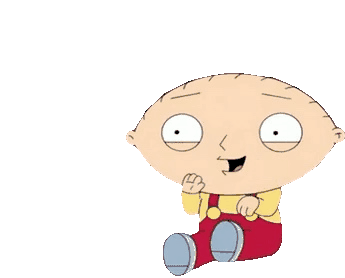

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Cross check </center></h1>
</div>

As suggested in the following notebook, "We have 486 samples from the test dataset that already exist in the train dataset 🏂🏻 => we already know the target of these samples" 
https://www.kaggle.com/hamzaghanmi/train-test-286
I have compared the predicted results with 486 samples that were already exist in training dataset, all of them are predicted perfectly. This means that there could be two different reasons.

1) Model is overfitted

2) Model predicted accurately

I belive second one is true because strong CV technique is used. 

## References:

Great thanks to all the kagglers who shared their notebooks. Please let me know if I have missed anyone in the references, glad to include them.

https://www.kaggle.com/marcobr95/predicting-bacteria-species

https://www.kaggle.com/sfktrkl/tps-feb-2022?scriptVersionId=87059305

https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense

https://www.kaggle.com/ambrosm/tpsfeb22-02-postprocessing-against-the-mutants

https://www.kaggle.com/ambrosm/tpsfeb22-03-clustering-improves-the-predictions

https://www.v7labs.com/blog/autoencoders-guide

https://towardsdatascience.com/principal-component-analysis-your-tutorial-and-code-9719d3d3f376

https://medium.com/@namanbhandari/extratreesclassifier-8e7fc0502c7

https://gem.app/product/official-family-guy-stewie-griffin-victory

https://www.kaggle.com/kavehshahhosseini/tps-feb-22-autoencoder-dimensionality-reduction